## Face Recogniton and Siamese Model - Attendance System

### Importing Libraries


In [1]:
import tensorflow as tf
import numpy as np
from keras_facenet import FaceNet
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from utils.face_mtcnn import *
import csv
import datetime

### Loading model


In [11]:
embedder = FaceNet()

### Loading images


In [5]:
base_dir = "data/p_train"
persons = os.listdir(base_dir)
images = {}
# image_paths = []
for person in persons:
    images[person] = []
    paths = os.listdir(os.path.join(base_dir,person))#[:5]
    for path in paths:
        # image_paths.append(os.path.join(base_dir,person,path))
        images[person].append(cv2.cvtColor(cv2.imread((os.path.join(base_dir,person,path))),cv2.COLOR_BGR2RGB))
print("Total number of people found = ", len(images))
n_users = len(images)


Total number of people found =  3


(-0.5, 767.5, 1023.5, -0.5)

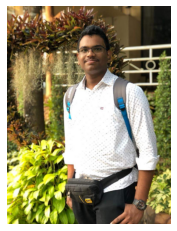

In [6]:
#sample image
plt.imshow(images['Sai'][2] , cmap = "gray")
plt.axis("off")

### Face Detection and Cropping


In [7]:
def Face_detection(images):
    
    crop_img = {}
    
    # faceCascade= cv2.CascadeClassifier("utils/haarcascade_frontalface_default.xml")
    for a in images.keys():
        crop_img[a] = []
        for img in images[a]:
            faces = detect_Faces_img(img)
            if len(faces) != 0:
                for b in faces:
                    (x,y,w,h) = b['box']
                    Cropped = img[y : y + h , x: x+w ]
                    crop_img[a].append(Cropped)  
        
    return crop_img

In [8]:
# cropped images
Crop_Images = Face_detection(images)

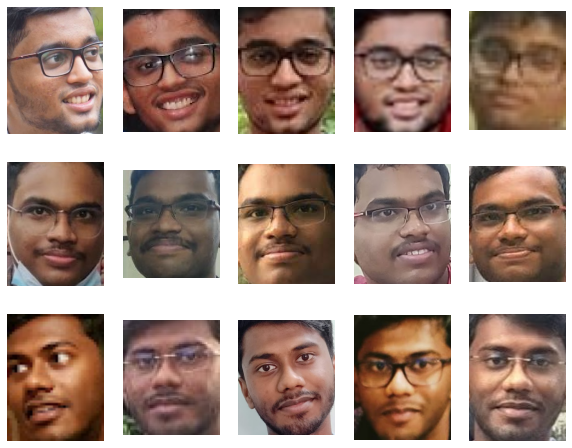

In [9]:
#plotting various faces found in our dataset!

fig , ax = plt.subplots(len(Crop_Images), 5 , figsize = (10,8))
i=1
for a in Crop_Images.keys():
    for j in range(5):
        plt.subplot(n_users,5,i)
        plt.axis("off")
        plt.imshow(Crop_Images[a][j])
        i += 1


### Embedding Extraction

In [10]:
embeddings = {}
for a in Crop_Images.keys():
    embeddings[a] = embedder.embeddings(Crop_Images[a])

In [11]:
#creating a database for people we expect to visit us.
database_size = 5
database = {}
for person in persons:
    database[str(person)] = embeddings[person]#[:database_size]
        
database

{'Dharshik': array([[ 0.00842226,  0.0006706 , -0.06648692, ..., -0.04911201,
         -0.01195213,  0.07586294],
        [ 0.01113827, -0.00772454, -0.01754724, ..., -0.01426534,
         -0.04028038,  0.02915881],
        [-0.03540595,  0.02968793, -0.03872759, ..., -0.00479118,
         -0.00881216,  0.07112157],
        [ 0.00205452,  0.0177503 , -0.0147542 , ..., -0.02472405,
         -0.06275312,  0.05357511],
        [ 0.00880656, -0.0669434 , -0.01783766, ...,  0.04864223,
         -0.0636962 ,  0.00636191]], dtype=float32),
 'Sai': array([[ 9.3155224e-03,  3.3276517e-02, -1.7333418e-02, ...,
         -6.0599122e-02, -2.0438418e-02, -1.2854670e-02],
        [ 1.9445519e-03,  3.9112666e-03, -2.8870236e-02, ...,
         -2.1806834e-02, -3.1055987e-03, -4.5290109e-02],
        [-4.5138288e-02,  8.1524260e-05, -6.0962599e-02, ...,
         -6.6695898e-03, -2.9683068e-02, -3.5232607e-02],
        [-1.9708961e-02,  2.8294919e-02, -4.4160806e-02, ...,
         -5.3488980e-03, -1.5086

In [12]:
database['Sai'].shape

(6, 512)

### Testing

In [20]:
def save_attendance(present):
    # open the file in the write mode
    f = open('log.csv', 'a')

    # create the csv writer
    writer = csv.writer(f)
    for a in present:
        # write a row to the csv file
        writer.writerow([a, datetime.datetime.now()])

    # close the file
    f.close()

In [14]:
def Face_recog(image_path , alpha = 2, output_file = False):
    '''
    image_path : list of individual input image path.
    alpha : it is a hyperparameter
    '''
    
    #detecting face
    img = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)
    faces = detect_Faces_img(img)
    crop_imgs = []
    if len(faces) != 0:
        for b in faces:
            (x,y,w,h) = b['box']
            Cropped = img[y : y + h , x: x+w ]
            crop_imgs.append(Cropped)  

    present = []
 
    img_embedding = embedder.embeddings(crop_imgs)
    # for crop in crop_imgs:
    #     img_embedding.append(embedder.embeddings(crop))
    
    #calculate dist wrt to database images
    
    i=0

    for embedding in img_embedding:
        min_dist = 100
        for (name,db_emb) in database.items():
            
            for emb in db_emb:
            
                dist = np.linalg.norm(embedding - db_emb)
                
                if dist < min_dist:
                    min_dist = dist
                    identity = name
        
        plt.axis("off")
        plt.imshow(crop_imgs[i])
        plt.show()
        i += 1    
        if min_dist > alpha:
            print("Not found in Database")
            
            
        else:
            print(f"{identity} identified")
            present.append(identity)
        print("Nearest: " + identity + " - " + str(min_dist))
    if output_file:
        save_attendance(present)
    

In [15]:
def Face_recog_avg(image_path , alpha = 2, output_file = False):
    '''
    image_path : list of individual input image path.
    alpha : it is a hyperparameter
    '''
    
    #detecting face
    img = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)
    faces = detect_Faces_img(img)
    crop_imgs = []
    if len(faces) != 0:
        for b in faces:
            (x,y,w,h) = b['box']
            Cropped = img[y : y + h , x: x+w ]
            crop_imgs.append(Cropped)  

    present = []
 
    img_embedding = embedder.embeddings(crop_imgs)
    # for crop in crop_imgs:
    #     img_embedding.append(embedder.embeddings(crop))
    
    #calculate dist wrt to database images
    
    i=0

    for embedding in img_embedding:
        min_dist = 100
        for (name,db_emb) in database.items():
            
            sum = 0
            for emb in db_emb:
                sum += np.linalg.norm(embedding - db_emb)
                
            dist = sum / len(db_emb)

            if dist < min_dist:
                min_dist = dist
                identity = name
        
        plt.axis("off")
        plt.imshow(crop_imgs[i])
        plt.show()
        i += 1    

        if min_dist > alpha:
            print("Not found in Database")
        
        else:
            print(f"{identity} identified")
            present.append(identity)
        print("Nearest: " + identity + " - " + str(min_dist))
    if output_file:
        save_attendance(present)
    

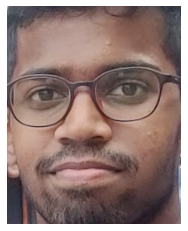

Not found in Database
Nearest: Sai - 2.574467897415161


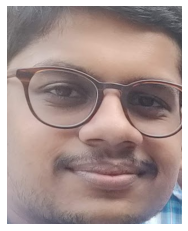

Not found in Database
Nearest: Sathiya - 2.464878797531128


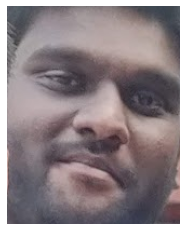

Not found in Database
Nearest: Dharshik - 2.528817653656006


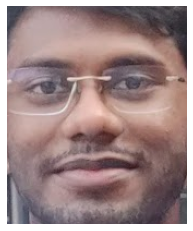

Sathiya identified
Nearest: Sathiya - 1.6135246753692627


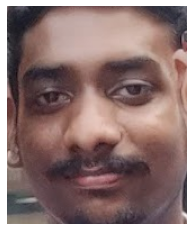

Not found in Database
Nearest: Sathiya - 2.557157039642334


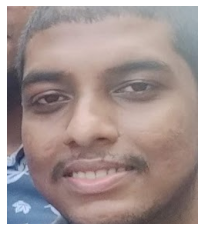

Not found in Database
Nearest: Dharshik - 2.612419366836548


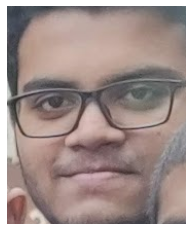

Not found in Database
Nearest: Dharshik - 2.498945951461792


In [21]:
test_img_path = 'data/p_test/test3.jpg'
Face_recog_avg(test_img_path,alpha = 1.8, output_file= True)

In [103]:
## Saving and Loading embeddings

In [7]:
emb_np = np.array(embeddings)

from numpy import save

save('data/emb.npy', emb_np)

In [14]:
from numpy import load
# load array
data = load('data/emb.npy', allow_pickle=True)
# print the array

database = dict(enumerate(data.flatten(), 1))[1]
print((database))

{'Dharshik': array([[ 0.00842226,  0.0006706 , -0.06648692, ..., -0.04911201,
        -0.01195213,  0.07586294],
       [ 0.01113827, -0.00772454, -0.01754724, ..., -0.01426534,
        -0.04028038,  0.02915881],
       [-0.03540595,  0.02968793, -0.03872759, ..., -0.00479118,
        -0.00881216,  0.07112157],
       [ 0.00205452,  0.0177503 , -0.0147542 , ..., -0.02472405,
        -0.06275312,  0.05357511],
       [ 0.00880656, -0.0669434 , -0.01783766, ...,  0.04864223,
        -0.0636962 ,  0.00636191]], dtype=float32), 'Sai': array([[ 9.3155224e-03,  3.3276517e-02, -1.7333418e-02, ...,
        -6.0599122e-02, -2.0438418e-02, -1.2854670e-02],
       [ 1.9445519e-03,  3.9112666e-03, -2.8870236e-02, ...,
        -2.1806834e-02, -3.1055987e-03, -4.5290109e-02],
       [-4.5138288e-02,  8.1524260e-05, -6.0962599e-02, ...,
        -6.6695898e-03, -2.9683068e-02, -3.5232607e-02],
       [-1.9708961e-02,  2.8294919e-02, -4.4160806e-02, ...,
        -5.3488980e-03, -1.5086544e-02, -6.41493